# Classifier with Continuous Actions

**idea:** classifier $c(x, a)$ predicts expected costs for taking an action $a$ when observing $x$

1. Sample from prior $\theta\sim p(\theta)$
2. Get observations from simulator $x\sim p(x|\theta)$
3. Sample actions $a\sim p(a)$
4. Train a neural network
    - feed forward NN with $x$ and $a$ as input
    - trained to predict the expected costs
    - loss L2 loss



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import matplotlib as mpl
import matplotlib.pyplot as plt

from loss_calibration.classifier_continuous import train, build_classifier
from loss_calibration.npe import train_npe
from loss_calibration.loss import SquaredLoss, RevGaussLoss
import loss_calibration.toy_example_continuous as toy
from loss_calibration.plot import plot_loss, plot_predictions
from loss_calibration.utils import load_data
from sbi.utils import BoxUniform

## Toy Example

#### Toy Example

In [3]:
prior = toy.get_prior()
simulator = toy.get_simulator()

# uniform distribution for actions
def get_action(size:int, low=0., high = 5.):
    samples =  BoxUniform([low], [high]).sample((size, ))
    return samples 

actions = get_action

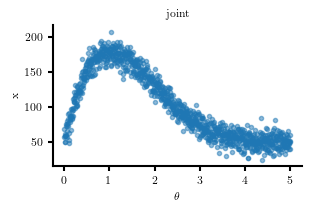

In [4]:
with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(3,2))
    thetas = torch.linspace(0, 5, 1000)
    ax.scatter(thetas, simulator(thetas), alpha=0.5); 
    ax.set_xlabel(r'$\theta$'); ax.set_ylabel('x'); ax.set_title('joint')
    #plt.savefig('results/1d_classifier/1D_clf_joint.pdf')
    plt.show()

Get data from task

In [5]:
theta_train, x_train, theta_val, x_val, theta_test, x_test = load_data("toy_example")
theta_train = theta_train[:50_000]
x_train = x_train[:50_000]
theta_val = theta_val[:5_000]
x_val = x_val[:5_000]
theta_test = theta_test[:5_000]
x_test = x_test[:5_000]

Load data from './data/toy_example', device = cpu.


#### Cost function

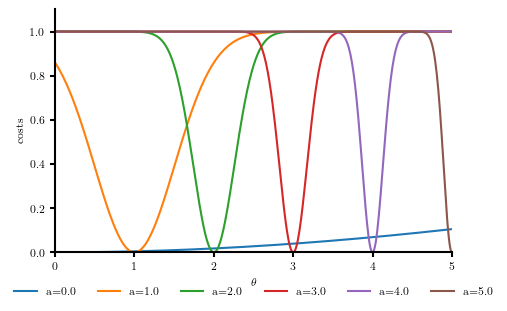

In [121]:
#loss = SquaredLoss(factor=1)
loss = RevGaussLoss(factor=0.75)
with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
        low, high = 0., 5.
        resolution = 500
        thetas = torch.arange(low, high, (high - low) / resolution)

        fig, ax = plt.subplots(1, 1, figsize=(5,3))
        for a in torch.arange(0,5.1,1):
                plt.plot(thetas, loss(thetas, a), label=f'a={a}')

        plt.xlabel(r'$\theta$')
        plt.ylabel('costs')
        plt.xlim(low, high)
        plt.ylim(0,1.1)
        plt.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, -0.1),
            fancybox=True,
            shadow=True,
            ncol=6,
        )
        plt.show()

#### Data Set: Actions and Costs

sample random actions and 

In [7]:
actions_train = get_action(theta_train.shape[0])
costs_train = loss(theta_train, actions_train)

actions_val = get_action(theta_val.shape[0])
costs_val = loss(theta_val, actions_val)

actions_test = get_action(theta_test.shape[0])
costs_test = loss(theta_test, actions_test)


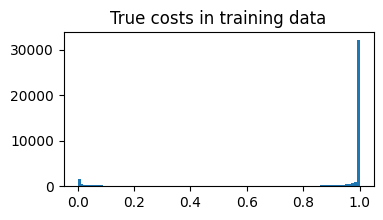

In [20]:
plt.figure(figsize=(4,2))
plt.hist(costs_train.numpy(), bins=100)
plt.title('True costs in training data')
plt.show()

#### Classifier

In [10]:
torch.manual_seed(8639)

clf = build_classifier("fc", x_train, actions_train, hidden_dims=[50,50,50], output_dim=1, activation=nn.ReLU(), output_transform=nn.Identity())
print(clf, end="\n-----\n")

clf, train_loss, val_loss = train(
    clf,
    x_train,
    actions_train,
    costs_train,
    x_val,
    actions_val,
    costs_val,
    learning_rate=1e-3,
    model_dir="./results/continuous/toy_example",
    max_num_epochs=800,
    stop_after_epochs=50,
)

FeedforwardNN(
  (standardize_layer): Standardize()
  (input_layer): Linear(in_features=2, out_features=50, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
  )
  (final_layer): Linear(in_features=50, out_features=1, bias=True)
  (activation): ReLU()
  (output_transform): Identity()
)
-----
Converged after 236 epochs. train_loss = 0.03348174	 last_improvement = 34


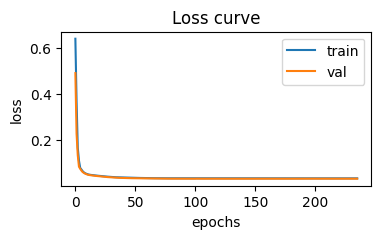

In [11]:
fig, ax = plt.subplots(1,1, figsize = (4,2))
ax.plot(train_loss, label="train")
ax.plot(val_loss, label = "val")
ax.set_title("Loss curve"); ax.set_xlabel("epochs"); ax.set_ylabel("loss")
ax.legend()
plt.show()

##### Check predictions on training data

In [12]:
predictions_train = clf(x_train, actions_train)

In [13]:
losses_train = torch.mean((costs_train - predictions_train)**2, dim=1)
torch.median(losses_train), torch.mean(losses_train)

(tensor(0.0004, grad_fn=<MedianBackward0>),
 tensor(0.0334, grad_fn=<MeanBackward0>))

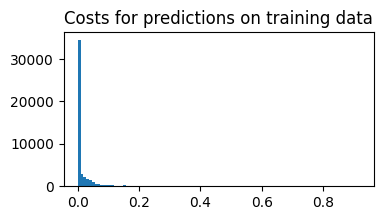

In [17]:
plt.figure(figsize=(4,2))
plt.hist(losses_train.detach().numpy(), bins=100)
plt.title("Costs for predictions on training data")
plt.show()

### Posterior and Expected Costs

Take example action and observation and check posterior and costs

In [77]:
a_o = 4
x_o = torch.tensor([170.]) #x_train[0]
x_o

tensor([170.])

In [78]:
lower, upper = 0., 5.
theta_grid = torch.linspace(lower, upper, resolution).unsqueeze(1)
post = toy.gt_posterior(x_o, lower, upper, resolution)

In [79]:
true_costs_taking_a = toy.evaluate_cost(theta_grid, actions=a_o)

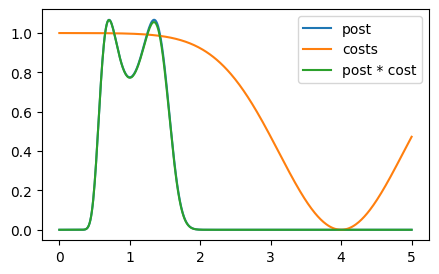

In [80]:
plt.figure(figsize=(5,3))
plt.plot(theta_grid, post, label='post')
plt.plot(theta_grid, true_costs_taking_a, label='costs')
plt.plot(theta_grid, (post * true_costs_taking_a ), label='post * cost')
#plt.ylim(-0.01,post.max())
plt.legend()
plt.show()

In [81]:
toy.expected_posterior_loss(x_o, a_o)

tensor(0.9925)

Which action is predicted under the posterior?

In [82]:
a_grid = torch.arange(0.,5.,0.05)

In [83]:
a_grid[0].unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1])

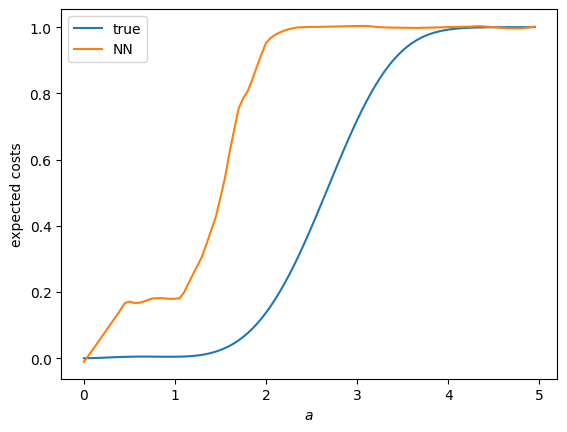

In [87]:
expected_posterior_losses = torch.tensor(
    [
        toy.expected_posterior_loss(
            x_o=x_o,
            a_o=a,
            lower=lower,
            upper=upper,
            resolution=resolution,
        )
        for a in a_grid
    ]
)

predicted_losses = torch.tensor([clf(x_o.unsqueeze(0), a.unsqueeze(0).unsqueeze(0)) for a in a_grid])


plt.plot(a_grid, expected_posterior_losses, label="true")
plt.plot(a_grid, predicted_losses, label="NN")
plt.xlabel(r'$a$'); plt.ylabel('expected costs')
plt.legend()
plt.show()

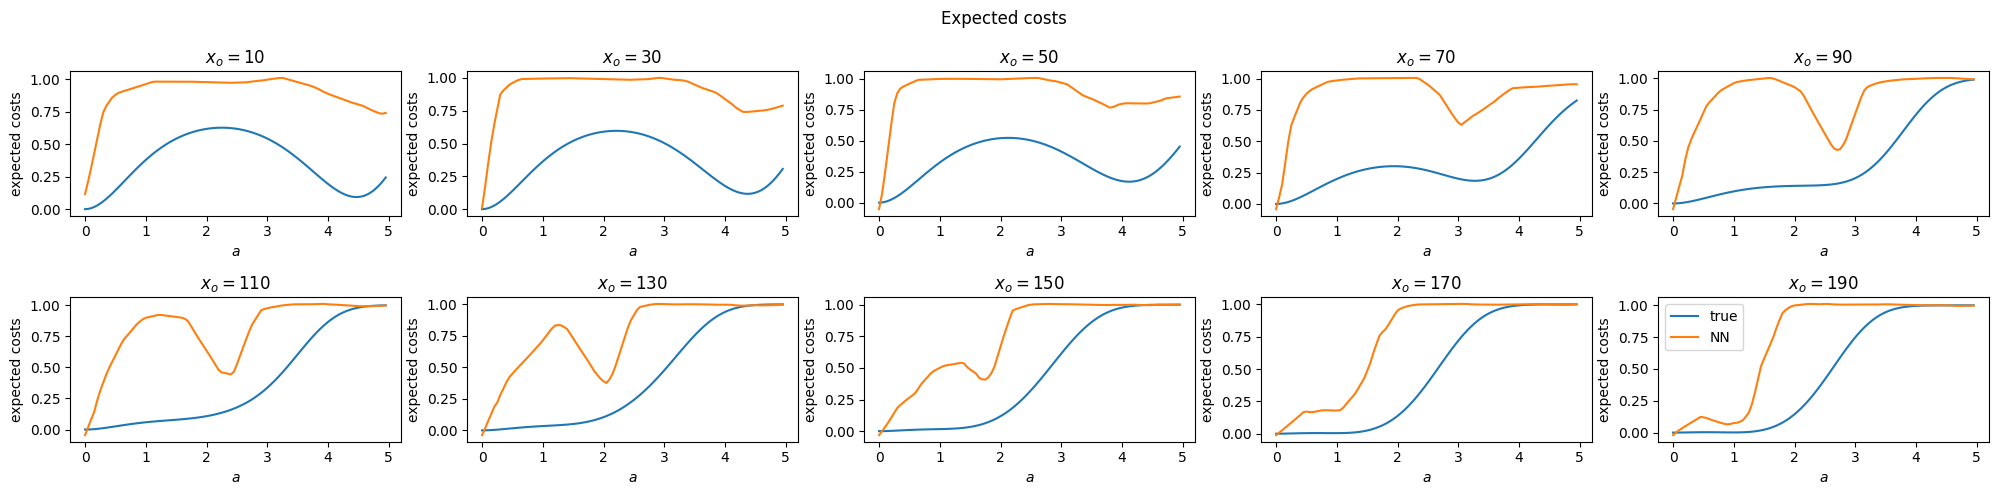

In [108]:
obs = torch.arange(10, 210, 20)

plt.figure(figsize=(20,5))
for i, x_o in enumerate(obs): 
    plt.subplot(2,5,i+1%5)

    expected_posterior_losses = torch.tensor(
        [
            toy.expected_posterior_loss(
                x_o=x_o,
                a_o=a,
                lower=lower,
                upper=upper,
                resolution=resolution,
            )
            for a in a_grid
        ]
    )

    predicted_losses = torch.tensor([clf(x_o.unsqueeze(0).unsqueeze(0), a.unsqueeze(0).unsqueeze(0)) for a in a_grid])


    plt.plot(a_grid, expected_posterior_losses, label="true")
    plt.plot(a_grid, predicted_losses, label="NN")
    plt.xlabel(r'$a$'); plt.ylabel('expected costs')
    plt.title(rf'$x_o=${x_o}')
plt.suptitle("Expected costs")
plt.tight_layout()
plt.legend()
plt.show()

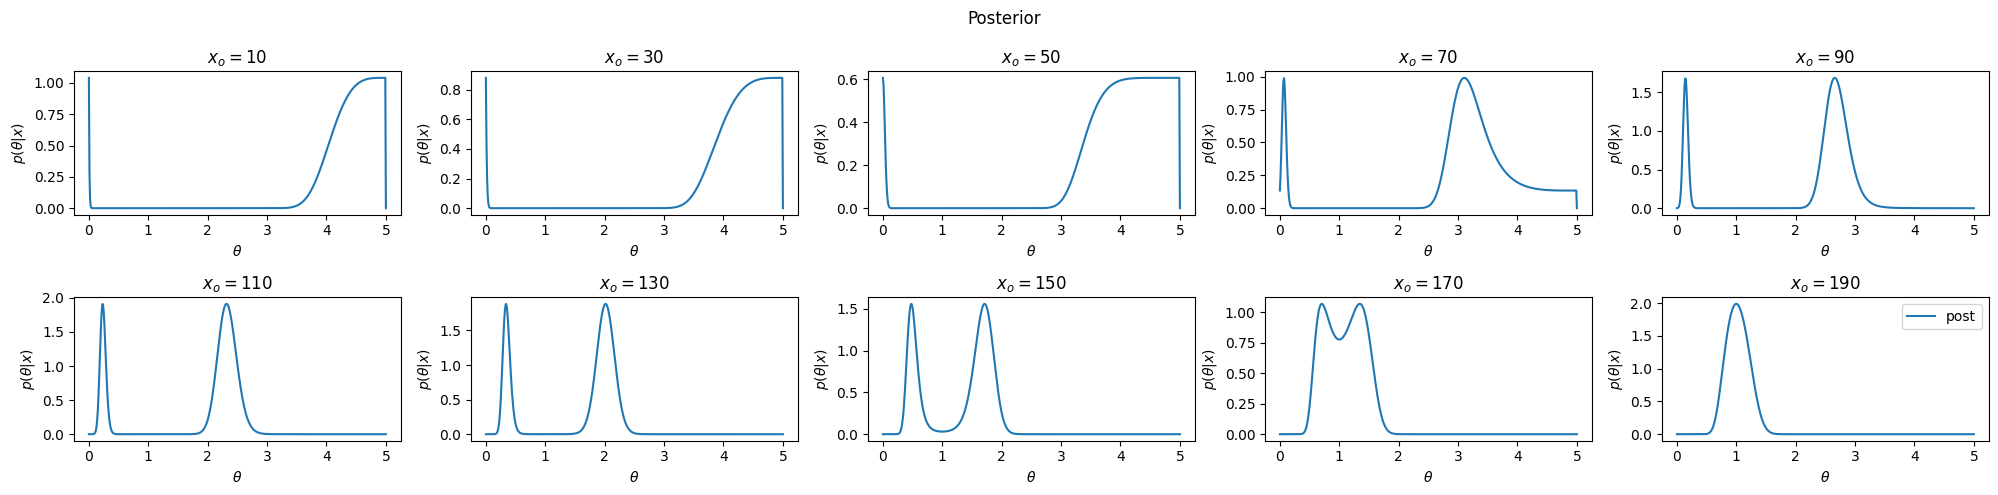

In [107]:
obs = torch.arange(10, 210, 20)

plt.figure(figsize=(20,5))
for i, x_o in enumerate(obs): 
    plt.subplot(2,5,i+1%5)

    post = toy.gt_posterior(x_o, lower, upper, resolution)
    plt.plot(theta_grid, post, label='post')

    plt.xlabel(r'$\theta$'); plt.ylabel(r'$p(\theta|x)$')
    plt.title(rf'$x_o=${x_o}')
plt.suptitle("Posterior")
plt.tight_layout()
plt.legend()
plt.show()